In [ ]:
import os
import glob
#from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import xml.etree.ElementTree as ET
import tensorflow as tf
from keras.models import load_model
import cv2

In [ ]:
! apt install tesseract-ocr
! apt install libtesseract-dev

In [ ]:
! pip install Pillow
! pip install pytesseract

In [ ]:
!sudo apt install tesseract-ocr

In [ ]:
import pytesseract
from PIL import ImageEnhance, ImageFilter, Image

In [ ]:
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

In [ ]:
!wget --header="Host: doc-0o-3o-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.77 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_sdg3i7v4ri7e38pdfprsctq13ekkc1am_nonce=c1egf3sdkpn4m" --header="Connection: keep-alive" "https://doc-0o-3o-docs.googleusercontent.com/docs/securesc/c7h9tlgpbqilf9nmomrdtg90qdn0nlc3/f65glvivvb631itipc8tmhakrnnkfrd6/1622441250000/00048055783660299439/13937806133259344158/1Ms3h7oNoWZxR0nnW_1D_Vq9F254wqSXp?e=download&authuser=0&nonce=c1egf3sdkpn4m&user=13937806133259344158&hash=u5o9bs33ia8ejnpv7ik7ib7ngnsviesh" -c -O 'Marmot_data.zip'

--2021-05-31 06:07:53--  https://doc-0o-3o-docs.googleusercontent.com/docs/securesc/c7h9tlgpbqilf9nmomrdtg90qdn0nlc3/f65glvivvb631itipc8tmhakrnnkfrd6/1622441250000/00048055783660299439/13937806133259344158/1Ms3h7oNoWZxR0nnW_1D_Vq9F254wqSXp?e=download&authuser=0&nonce=c1egf3sdkpn4m&user=13937806133259344158&hash=u5o9bs33ia8ejnpv7ik7ib7ngnsviesh
Resolving doc-0o-3o-docs.googleusercontent.com (doc-0o-3o-docs.googleusercontent.com)... 64.233.189.132, 2404:6800:4008:c07::84
Connecting to doc-0o-3o-docs.googleusercontent.com (doc-0o-3o-docs.googleusercontent.com)|64.233.189.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘Marmot_data.zip’

Marmot_data.zip         [   <=>              ]  65.63M   161MB/s    in 0.4s    

2021-05-31 06:07:54 (161 MB/s) - ‘Marmot_data.zip’ saved [68820548]



In [ ]:
!unzip Marmot_data.zip

In [ ]:
!git clone https://github.com/mawanda-jun/TableTrainNet.git

Cloning into 'TableTrainNet'...
remote: Enumerating objects: 4268, done.
remote: Total 4268 (delta 0), reused 0 (delta 0), pack-reused 4268
Receiving objects: 100% (4268/4268), 1.85 GiB | 16.07 MiB/s, done.
Resolving deltas: 100% (1273/1273), done.
Checking out files: 100% (4147/4147), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Dropout, Dense, Flatten, Input, Concatenate, UpSampling2D, Conv2DTranspose

In [ ]:
def table_decoder(x, vgg19_pool3, vgg19_pool4):
  x = Conv2D(512, (1,1), activation = 'relu', name = 'conv7_table')(x)
  x = UpSampling2D((2,2), name = '2xconv7_table')(x)
  x = Concatenate()([x,vgg19_pool4])
  x = UpSampling2D((2,2), name = '2x_pool4_2xconv7_table')(x)
  x = Concatenate()([x, vgg19_pool3])
  x = UpSampling2D(size=(2,2))(x)
  x = UpSampling2D(size=(2,2))(x)
  x =  Conv2DTranspose(3,3, strides= 2 , padding = 'same', name = 'table_mask')(x)
  return x

In [ ]:
def column_decoder(x, vgg19_pool3, vgg19_pool4):
  x = Conv2D(512, (1,1), activation='relu', name = 'conv7_column')(x)
  x = Dropout(0.8)(x)
  x = Conv2D(512, (1,1), activation='relu', name = 'conv8_column')(x)
  x = UpSampling2D((2,2), name = '2xconv8_column')(x)
  x = Concatenate()([x, vgg19_pool4])
  x = UpSampling2D((2,2), name = '2x_pool4_2xconv8_column')(x)
  x = Concatenate()([x, vgg19_pool3])
  x = UpSampling2D(size=(2,2))(x)
  x = UpSampling2D(size=(2,2))(x)
  x =  Conv2DTranspose(3,3, strides=2, padding = 'same', name = 'column_mask')(x)
  return x

In [ ]:
tf.keras.backend.clear_session()
input = Input((256,256,3), name = 'input')
vgg_19 = tf.keras.applications.VGG19(include_top=False, weights = 'imagenet', input_tensor=input)
print(f'VGG19 ouput shape :{vgg_19.output_shape}')
vgg19_pool3 = vgg_19.get_layer('block3_pool').output
print(f'VGG19 pool3 layer output shape : {vgg19_pool3.shape}')
vgg19_pool4 = vgg_19.get_layer('block4_pool').output
print(f'VGG19 pool4 layer output shape : {vgg19_pool4.shape}')

x = Conv2D(512, (1,1), activation='relu', name = 'block6_conv1')(vgg_19.output)
x = Dropout(0.8)(x)
x = Conv2D(512, (1,1), activation='relu', name = 'block6_conv2')(x)
x = Dropout(0.8)(x)
print(f'Shape of encoder output: {x.shape}')

80142336/80134624 [==============================] - 1s 0us/step
VGG19 ouput shape :(None, 8, 8, 512)
VGG19 pool3 layer output shape : (None, 32, 32, 256)
VGG19 pool4 layer output shape : (None, 16, 16, 512)
Shape of encoder output: (None, 8, 8, 512)


In [ ]:
table_mask = table_decoder(x, vgg19_pool3, vgg19_pool4)
column_mask = column_decoder(x, vgg19_pool3, vgg19_pool4)

In [ ]:
model =  Model(inputs = input, outputs = [table_mask, column_mask], name = 'tablenet')

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/tablenet_new/model_148')

In [ ]:
def predict(filepath):
  img = cv2.imread(filepath)
  img = cv2.resize(img,(1024,1024), cv2.INTER_AREA)
  img_256 = cv2.resize(img,(256,256), cv2.INTER_NEAREST)
  if img_256.shape[2] == 4:
    img_256 = cv2.cvtColor(img_256, cv2.COLOR_RGBA2RGB)
  elif img_256.shape[2] == 1:
    img_256 = cv2.cvtColor(img_256, cv2.COLOR_GRAY2RGB)
  else:
    img_256 = cv2.cvtColor(img_256, cv2.COLOR_BGR2RGB)
  img_256 = np.expand_dims(img_256, axis = 0)
  print('Predicting....')
  pred_mask1, pred_mask2 = model.predict(img_256)

  pred_tabmask = tf.argmax(pred_mask1, axis=-1)
  pred_tabmask = pred_tabmask[..., tf.newaxis]
  pred_colmask = tf.argmax(pred_mask2, axis=-1)
  pred_colmask = pred_colmask[..., tf.newaxis]
  pred_table_mask = pred_tabmask[0]
  pred_column_mask = pred_colmask[0]

  pred_table_mask = tf.keras.preprocessing.image.array_to_img(pred_table_mask)
  pred_column_mask = tf.keras.preprocessing.image.array_to_img(pred_column_mask)
  pred_table_mask = cv2.resize(np.array(pred_table_mask), (1024,1024), cv2.INTER_NEAREST)
  pred_column_mask = cv2.resize(np.array(pred_column_mask), (1024,1024), cv2.INTER_NEAREST)
  pred_table_mask = tf.keras.preprocessing.image.array_to_img(pred_table_mask[:,:,np.newaxis])
  pred_column_mask = tf.keras.preprocessing.image.array_to_img(pred_column_mask[:,:,np.newaxis])

  img_final = tf.keras.preprocessing.image.array_to_img(img)
  img_final.putalpha(pred_table_mask)
  print('Extracting text...')
  text = pytesseract.image_to_string(img_final)
  plt.figure(figsize = (20,20))
  #plt.imshow(img)
  title = ['Original image', 'Predicted Table']
  for i in range(2):
    plt.subplot(1,2,i+1)
    if i ==0:
      plt.title(title[i])
      plt.imshow(img)
    elif i ==1:
      plt.title(title[i])
      plt.imshow(img_final)
  if len(text) ==1:
    print('No table is present in the image')
  else:
    print(text)

Let us now try to predict the table mask on different types of images.

1. Image with no table present

Predicting....
Extracting text...
No table is present in the image


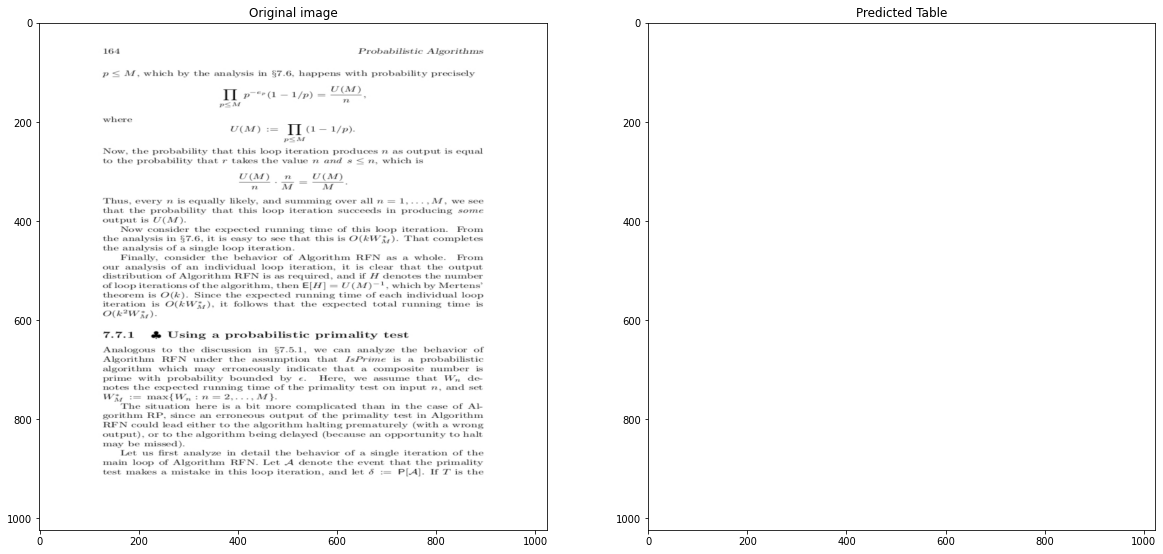

In [ ]:
predict('/content/TableTrainNet/dataset/Images/POD_0002.bmp')

The model is able to identify that no table is present in the image

2. Image with table

Predicting....
Extracting text...
 

 

32

ations was run Using tho 113 mode! to charefarize pli.ww wee.
t ai the Rict har Gites Th

we SO" and Sy pe.ventile speec a vari Ske. ore used.
ers. Currents for the Richton sites were extracren irom

  

   

avacionn oe the __5 near-field n
eRichtor 1 narge ses Current
speed: oir toe OF the oncoming cur

 

 

 

 

 

 

 

 

Richton North LJ
1.24 oO
5.53 45
13.8 12.87 90 31 20
Richton South
4.10 o I
| 3.23 45 ;
1168 7.38 90 5 at

 



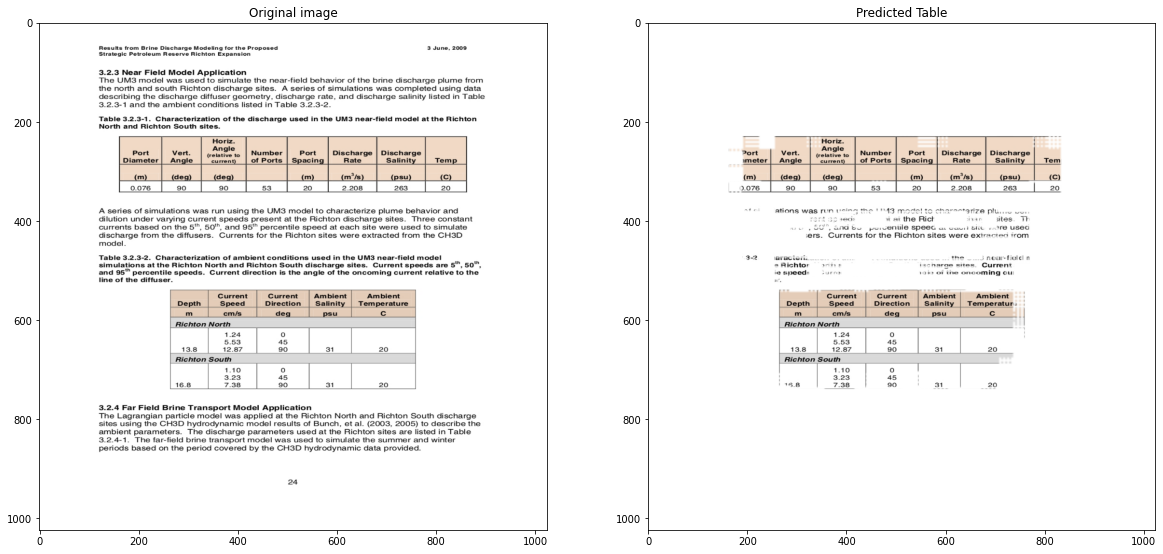

In [ ]:
predict('/content/TableTrainNet/dataset/Images/POD_0003.bmp')

The model is able to detect the table in the image

3. Blank Image

Predicting....
Extracting text...
No table is present in the image


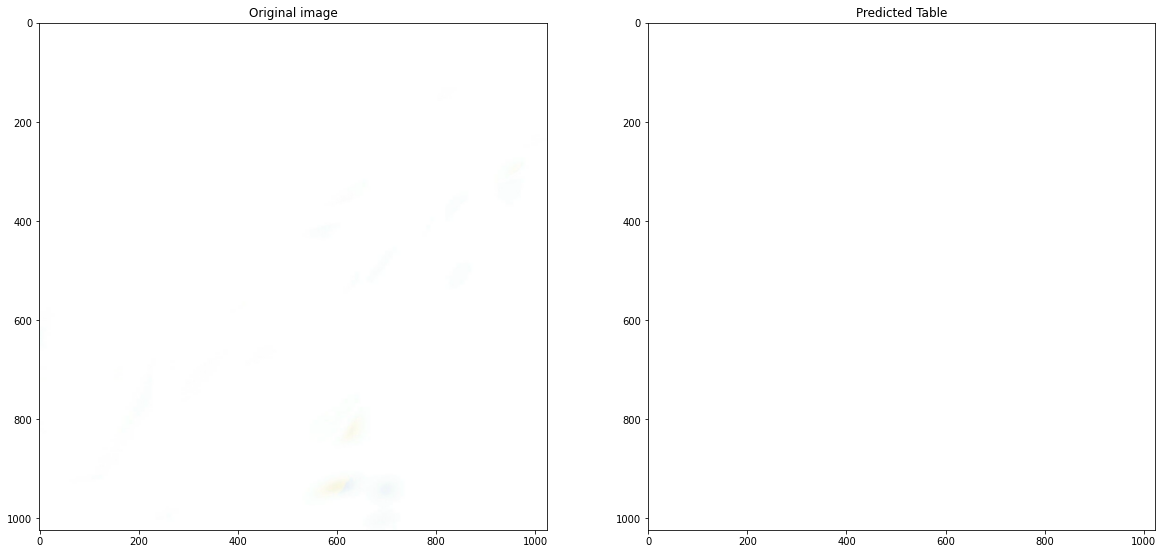

In [ ]:
predict('/content/blank_image.jpg')

The model is able to predict that there is no table in a blank image

4. Image with only table

Predicting....
Extracting text...
No table is present in the image


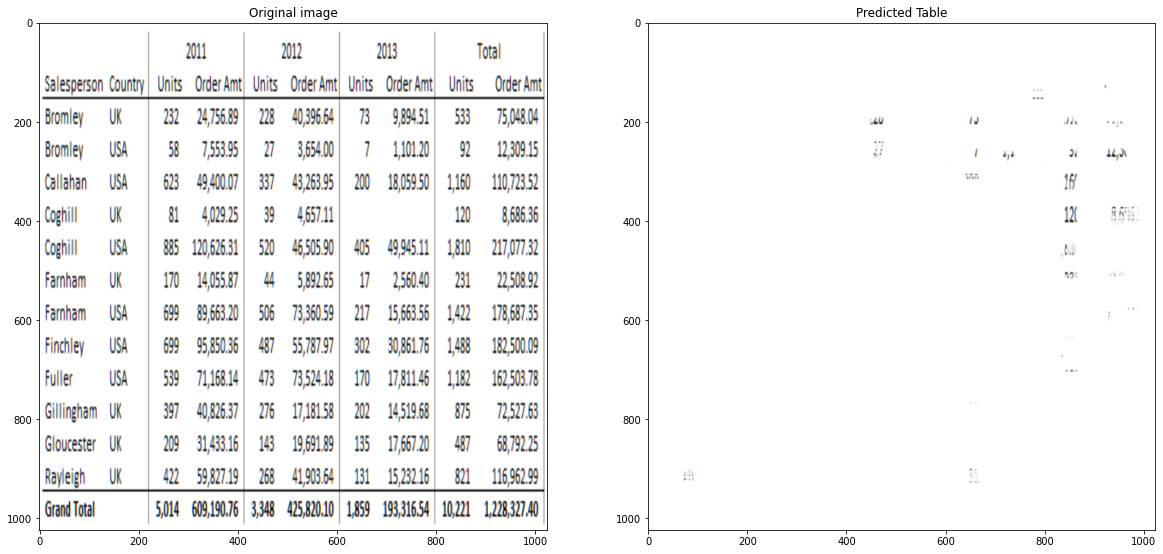

In [ ]:
predict('/content/table_image.png')

The model is not able to detect the table when the table is present in the whole image. This may be because we have very less training data

Predicting....
Extracting text...
pectin
0.0033 0.0930 =
0.0033 0.0930 0.1768

 

    



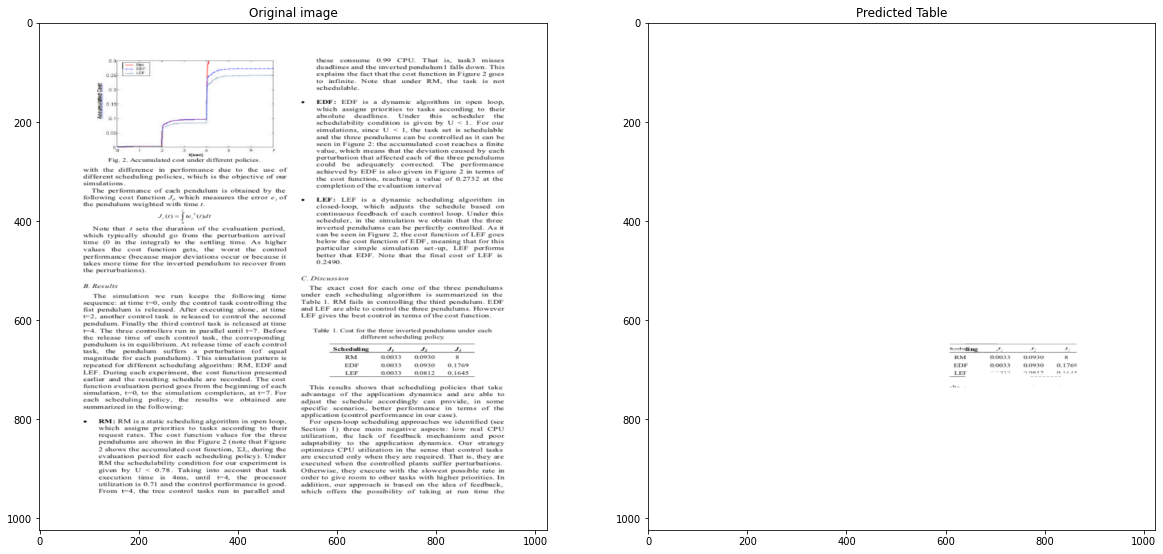

In [ ]:
predict('/content/10.1.1.1.2006_3.bmp')

Predicting....
Extracting text...
Years

 

tate 1990 1991 1992 1993 1994 199°
setivity rate (15-64)"*
Urban Male 720 70.8 69.8 70.8 70.5 69.9
Female 224 20.3 19.1 20.3 20.2 19.5
Total 473 437 444 457 45.4 44.
Rural Male 78.2 76.8 763 763 76.1 76.
Female 34.7 29.3 26.1 24.0 25.4 234
Total 56.4 53.0 50.8 50.2 51.0 49.7
Total Male 753 74.0 73.2 73.7 735 73.
Female 29.0 25.2 22.8 22.3 23.0 21.
Total S24 49.6 478 48.1 4R4 aT
mployment rate (15-64)**
Urban Male 67.0 653 64.7 649 649 64.
Female 16.8 15.4 143 14.6 14.6 14
Total 424 40.5 39.5 39.9 39.8 39.
Rural Male 74.5 72.4 718 709 70.7 70.
Female 316 26.2 22.8 19.5 20.4 18.
Total 33.0 493 46.9 433 45.8 44
Total Male 710 69.4 68s 68.1 68.0 67.
Female 24.7 244 18.9 172 177 16.
Total 479 452 434 42.8 43.0 420
employment Rate (15-64)**
Urban Male 69 77 73 84 Te
Female 24.8 244 249 279 274
Total Ma 14 Ma 12.7 1s
Toral Male a7 37 39 70 7
Female 90 10.8 12.5 18.7 21
Total 6.0 7 76 Os 10
Toial Male 37 66 6S 76 7
Female 147 15.9 173 22.7 24.
Total 

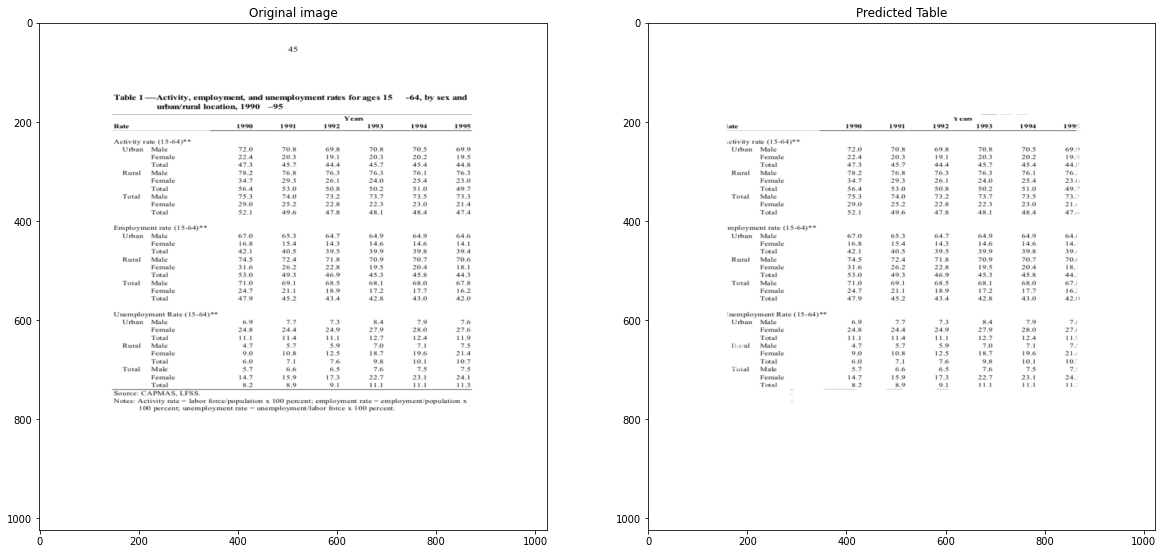

In [ ]:
predict('/content/10.1.1.1.2013_63.bmp')

In [ ]:
def get_filesize(filepath):
  size = 0
  for f in os.listdir(filepath):
    if 'model' in f:
      size += os.path.getsize(os.path.join(filepath,f))
    elif 'variables' in f:
      new_path = os.path.join(filepath,f)
      for _ in os.listdir(new_path):
        size += os.path.getsize(os.path.join(new_path,_))
  print('File Size : ' + str(round(size /(1024 *1024),3)) + ' MB')

In [ ]:
get_filesize('/content/drive/MyDrive/Colab Notebooks/tablenet_new/model_148')

File Size : 245.805 MB


In [ ]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpy63a5ntl/assets
